In [1]:
# del model
# del X_train,Y_train

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import one_hot
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output
import gc

2024-04-26 20:49:47.077194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 20:49:47.077262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 20:49:47.192222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 20:49:47.329379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CATEGORIES = os.listdir("./data/train")
CATEGORIES

['Fat Hen',
 'Maize',
 'Small-flowered Cranesbill',
 'Common Chickweed',
 'Common wheat',
 'Charlock',
 'Black-grass',
 'Loose Silky-bent',
 'Shepherds Purse',
 'Scentless Mayweed',
 'Cleavers',
 'Sugar beet']

In [3]:

# initial_learning_rate = 0.003 #initial rate
# # Rate decay with exponential decay
# # new rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
# #step per epoch = 95
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=480,
#     decay_rate=0.5,
#     staircase=False)

In [4]:
pretrained = xception.Xception(input_shape=[240,240, 3], include_top=False)

2024-04-26 20:50:01.662170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-04-26 20:50:01.664954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79087 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-04-26 20:50:01.669134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79087 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


In [5]:
pretrained.trainable = True

In [6]:
model = tf.keras.Sequential([
    pretrained,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.BatchNormalization(trainable = True,axis=1),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.BatchNormalization(trainable = True,axis=1),
    
    tf.keras.layers.Dense(12,activation='softmax')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 batch_normalization_4 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [8]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.4,1],
    rescale=1.0/255.0)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
pathh = "./data/train/"

In [12]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="model/weights.best_{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', 
                             verbose=1, save_best_only=True, mode='max')
filepath="model/weights.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='accuracy', 
                                 verbose=1, save_best_only=False, mode='max')

# all callbacks
callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]

result = model.fit(train_datagen.flow_from_directory(pathh,
                                        target_size=(240, 240), 
                                        color_mode='rgb', 
                                        class_mode='categorical', 
                                        batch_size=64, 
                                        shuffle=True),
                    epochs=7,
                    verbose=1,callbacks=callbacks_list)

Found 4750 images belonging to 12 classes.
Epoch 1/7
75/75 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.9116
Epoch 1: accuracy improved from -inf to 0.91158, saving model to model/weights.best_01-0.91.hdf5


/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: saving model to model/weights.last_auto4.hdf5
75/75 [==============================] - 92s 1s/step - loss: 0.3068 - accuracy: 0.9116 - lr: 0.0010
Epoch 2/7
75/75 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.9141
Epoch 2: accuracy improved from 0.91158 to 0.91411, saving model to model/weights.best_02-0.91.hdf5

Epoch 2: saving model to model/weights.last_auto4.hdf5
75/75 [==============================] - 88s 1s/step - loss: 0.3005 - accuracy: 0.9141 - lr: 0.0010
Epoch 3/7
75/75 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9413
Epoch 3: accuracy improved from 0.91411 to 0.94126, saving model to model/weights.best_03-0.94.hdf5

Epoch 3: saving model to model/weights.last_auto4.hdf5
75/75 [==============================] - 137s 2s/step - loss: 0.1910 - accuracy: 0.9413 - lr: 0.0010
Epoch 4/7
75/75 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9556
Epoch 4: accuracy improved from 0.94126 to 0.95558, 

In [13]:
result.history.keys()

dict_keys(['loss', 'accuracy', 'lr'])

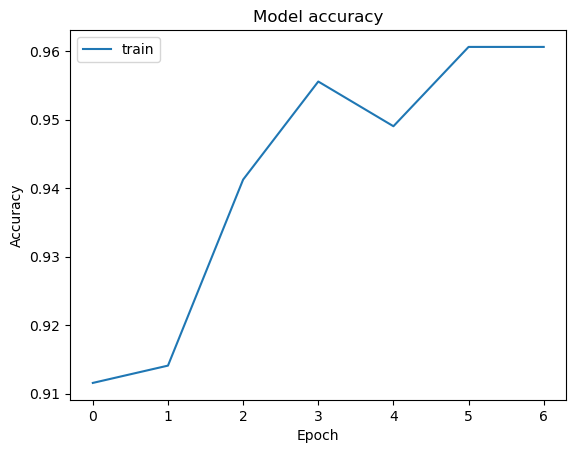

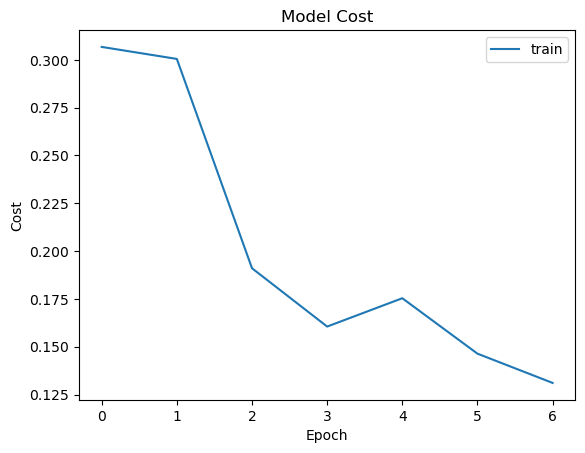

In [14]:
plt.plot(result.history['accuracy'], label='train')
# plt.plot(result.history['val_accuracy'], label='valid')
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.plot(result.history['loss'], label='train')
# plt.plot(result.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

140
0.0006
160
0.0001
180
0.00001